# Re-create vertical profile plots using tslist output
Read tslist pdata and plot vertical profile, along with obs

### File Path info

In [1]:
do_spectra = False
################################################################################
##Path to WRF output files
WRF_path = '/p/lscratchh/lassman1/a2e-mmc/pdata/FINO/'


## WRF pdata files, each containing 1 hour of output
# Control simulation
WRF_fncontrol = WRF_path + 'setup_2_tslist_control.nc'

# Cell Perturbation Method (CPM) Simulation
WRF_fncpm = WRF_path + 'setup_2_tslist_cpm.nc'



In [2]:
################################################################################
# FINO1 data path
FINO_fpath = '/g/g12/lassman1/mmc/Data/FINO/FINO1_obs.nc'
#FINO_turbdata = 


In [3]:
################################################################################
# File path to save figures
save_fig_dir = '/g/g12/lassman1/mmc/Figures/FINO/microscale_v_prof_analysis/'

### Import python modules. <br>
MMCtools is pointed to using os to find the path, but this can also be installed with conda.

In [4]:
# Import modules

import numpy as np
from netCDF4 import Dataset as nc
import xarray as xr
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap                                                                                         
import pandas as pd
import datetime
import sys
import os

import geopandas as gpd
import cartopy as ctp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ssl

import wrf as wrfpy
import glob


module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/mmctools/')
#module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/')                                                          
if module_path not in sys.path:
    sys.path.append(module_path)

print(module_path)
from matplotlib.colors import Normalize, LinearSegmentedColormap

#from taylorDiagram import TaylorDiagram
from statsmodels.nonparametric.smoothers_lowess import lowess

from mmctools.helper_functions import theta_to_T, lowess_mean
from mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file


/g/g12/lassman1/mmc/mmc_github_clones/mmctools/


### Constants, lat/lon coordinates of FINO 1 tower, etc...

In [5]:
FINO_1_lat = 54.0148
FINO_1_lon = 6.587638

TH0 = 300



### Load data

In [6]:
# WRF output for both simulations, formatted the same
ds_control = xr.open_dataset( WRF_fncontrol )#, concat_dim = 'datetime' )
ds_cpm = xr.open_dataset( WRF_fncpm )#, concat_dim = 'datetime' )

In [7]:
print(ds_control.coords)
print(ds_control.dims)
print(ds_control.variables)

Coordinates:
    lat       (station) float64 ...
    lon       (station) float64 ...
    zsurface  (station) float64 ...
  * datetime  (datetime) datetime64[ns] 2010-05-16T01:18:00.025000 ... 2010-0...
  * station   (station) object 'ARR06' 'ARR07' 'ARR08' 'ARR09'
    height    (datetime, nz, station) float64 ...
Frozen(SortedKeysDict({'datetime': 514200, 'nz': 25, 'station': 4, 'j': 1, 'i': 1}))
Frozen({'ph': <xarray.Variable (datetime: 514200, nz: 25, station: 4)>
[51420000 values with dtype=float64], 'pr': <xarray.Variable (datetime: 514200, nz: 25, station: 4)>
[51420000 values with dtype=float64], 'qv': <xarray.Variable (datetime: 514200, nz: 25, station: 4)>
[51420000 values with dtype=float64], 'theta': <xarray.Variable (datetime: 514200, nz: 25, station: 4)>
[51420000 values with dtype=float64], 'u': <xarray.Variable (datetime: 514200, nz: 25, station: 4)>
[51420000 values with dtype=float64], 'v': <xarray.Variable (datetime: 514200, nz: 25, station: 4)>
[51420000 values with d

In [8]:
# Resample to 10 minute averages
ds_10mrs_cpm = ds_cpm.resample({'datetime': '600s'}).mean()
ds_10mrs_control = ds_control.resample({'datetime': '600s'}).mean()

/g/g12/lassman1/anaconda3/envs/mmc/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/g/g12/lassman1/anaconda3/envs/mmc/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [9]:
print( ds_10mrs_cpm.datetime)

<xarray.DataArray 'datetime' (datetime: 23)>
array(['2010-05-16T01:20:00.000000000', '2010-05-16T01:30:00.000000000',
       '2010-05-16T01:40:00.000000000', '2010-05-16T01:50:00.000000000',
       '2010-05-16T02:00:00.000000000', '2010-05-16T02:10:00.000000000',
       '2010-05-16T02:20:00.000000000', '2010-05-16T02:30:00.000000000',
       '2010-05-16T02:40:00.000000000', '2010-05-16T02:50:00.000000000',
       '2010-05-16T03:00:00.000000000', '2010-05-16T03:10:00.000000000',
       '2010-05-16T03:20:00.000000000', '2010-05-16T03:30:00.000000000',
       '2010-05-16T03:40:00.000000000', '2010-05-16T03:50:00.000000000',
       '2010-05-16T04:00:00.000000000', '2010-05-16T04:10:00.000000000',
       '2010-05-16T04:20:00.000000000', '2010-05-16T04:30:00.000000000',
       '2010-05-16T04:40:00.000000000', '2010-05-16T04:50:00.000000000',
       '2010-05-16T05:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * datetime  (datetime) datetime64[ns] 2010-05-16T01:20:00 ... 2010-05-16

In [10]:
print(ds_10mrs_cpm.ph.values[0,:,0])

[  5.  10.  15.  20.  25.  30.  33.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 110. 125. 150. 200.]


In [11]:
print("******************************************************************")
print("ds_10min_cpm, coords:", ds_10mrs_cpm.coords)
print("******************************************************************")
print("ds_10min_cpm, dims:", ds_10mrs_cpm.dims)
print("******************************************************************")
print("ds_10min_cpm, Variables:", ds_10mrs_cpm.variables)

******************************************************************
ds_10min_cpm, coords: Coordinates:
  * datetime  (datetime) datetime64[ns] 2010-05-16T01:20:00 ... 2010-05-16T05...
    lat       (station) float64 54.02 54.02 54.02 54.01
    lon       (station) float64 6.542 6.558 6.573 6.588
    zsurface  (station) float64 0.0 0.0 0.0 0.0
  * station   (station) object 'ARR06' 'ARR07' 'ARR08' 'ARR09'
******************************************************************
ds_10min_cpm, dims: Frozen(SortedKeysDict({'datetime': 23, 'i': 1, 'j': 1, 'nz': 25, 'station': 4}))
******************************************************************
ds_10min_cpm, Variables: Frozen({'datetime': <xarray.IndexVariable 'datetime' (datetime: 23)>
array(['2010-05-16T01:20:00.000000000', '2010-05-16T01:30:00.000000000',
       '2010-05-16T01:40:00.000000000', '2010-05-16T01:50:00.000000000',
       '2010-05-16T02:00:00.000000000', '2010-05-16T02:10:00.000000000',
       '2010-05-16T02:20:00.000000000', '2010-

In [12]:
# FINO 1 processed obs

ds_obs = xr.open_dataset( FINO_fpath )



In [13]:
# Display dims, coords, and variables (comment this out if you don't care)
print("******************************************************************")
print("ds_obs, coords:", ds_obs.coords)
print("******************************************************************")
print("ds_obs, dims:", ds_obs.dims)
print("******************************************************************")
print("ds_obs, Variables:", ds_obs.variables)
# Important variables and coords used in this analysis:
#      Vertical coordinate (z) is different depending on variable of interest. For example, use 'spd_levels' for windspeed heights
#      Windspeed [wspd] [m/s]
#      Temperature [temp] [k]
#

******************************************************************
ds_obs, coords: Coordinates:
  * anm_levels  (anm_levels) float64 40.0 60.0 80.0
  * datetime    (datetime) datetime64[ns] 2010-01-01T00:10:00 ... 2011-01-01
  * rh_levels   (rh_levels) float64 30.0 50.0
  * tmp_levels  (tmp_levels) float64 30.0 40.0 50.0 70.0 100.0
  * dir_levels  (dir_levels) float64 33.0 40.0 50.0 60.0 70.0 80.0 90.0
  * spd_levels  (spd_levels) float64 33.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * sst_levels  (sst_levels) float64 0.0
  * pcp_levels  (pcp_levels) float64 90.0
  * rad_levels  (rad_levels) float64 30.0
******************************************************************
ds_obs, dims: Frozen(SortedKeysDict({'spd_levels': 8, 'datetime': 61032, 'dir_levels': 7, 'tmp_levels': 5, 'sst_levels': 1, 'pcp_levels': 1, 'rh_levels': 2, 'rad_levels': 1, 'anm_levels': 3}))
******************************************************************
ds_obs, Variables: Frozen({'wspd': <xarray.Variable (spd_levels:

In [22]:
# Load SOWFA
dssowfa = xr.open_dataset('/p/lscratchh/lassman1/a2e-mmc/pdata/FINO/tslist_profiles/dssowfa_10minmean_4masts.nc' )

In [25]:
print(dssowfa.data_vars)
print(dssowfa.dims)
print(dssowfa.coords)

Data variables:
    u        (datetime, x, y, height) float64 ...
    v        (datetime, x, y, height) float64 ...
    w        (datetime, x, y, height) float64 ...
Frozen(SortedKeysDict({'datetime': 24, 'x': 2, 'y': 2, 'height': 200}))
Coordinates:
  * datetime  (datetime) datetime64[ns] 2010-05-16T01:00:00 ... 2010-05-16T04...
  * x         (x) float64 0.0 1e+03
  * y         (y) float64 0.0 -1e+03
  * height    (height) float64 5.0 15.0 25.0 ... 1.975e+03 1.985e+03 1.995e+03


In [29]:
dssowfa['wspd'] = np.sqrt( dssowfa['u']**2. + dssowfa['v']**2. )

In [27]:
dssowfa = xr.concat([dssowfa.isel(x=0,y=0, drop=True).expand_dims('station').assign_coords({'station':[0]}),
                     dssowfa.isel(x=0,y=1, drop=True).expand_dims('station').assign_coords({'station':[1]}),
                     dssowfa.isel(x=1,y=0, drop=True).expand_dims('station').assign_coords({'station':[2]}),
                     dssowfa.isel(x=1,y=1, drop=True).expand_dims('station').assign_coords({'station':[3]})],
                     dim='station')

In [30]:
print(dssowfa.data_vars)
print(dssowfa.dims)
print(dssowfa.coords)

Data variables:
    u        (station, datetime, height) float64 8.434 9.604 ... 11.01 11.04
    v        (station, datetime, height) float64 -4.829 -5.602 ... -12.5 -12.48
    w        (station, datetime, height) float64 -0.03961 ... -0.0002886
    wspd     (station, datetime, height) float64 9.719 11.12 ... 16.66 16.66
Frozen(SortedKeysDict({'height': 200, 'datetime': 24, 'station': 4}))
Coordinates:
  * height    (height) float64 5.0 15.0 25.0 ... 1.975e+03 1.985e+03 1.995e+03
  * datetime  (datetime) datetime64[ns] 2010-05-16T01:00:00 ... 2010-05-16T04...
  * station   (station) int64 0 1 2 3


In [37]:
ds_mst = xr.open_dataset('/p/lscratchh/lassman1/a2e-mmc/pdata/FINO/tslist_profiles/profile_ARR09.nc')

In [38]:
print(ds_mst.data_vars)
print(ds_mst.dims)
print(ds_mst.coords)

Data variables:
    u        (minutes, hgt) float64 ...
    v        (minutes, hgt) float64 ...
    w        (minutes, hgt) float64 ...
Frozen(SortedKeysDict({'minutes': 24, 'hgt': 25}))
Coordinates:
  * minutes  (minutes) float64 10.0 20.0 30.0 40.0 ... 210.0 220.0 230.0 240.0
  * hgt      (hgt) float64 5.0 10.0 15.0 20.0 25.0 ... 110.0 125.0 150.0 200.0


In [39]:
ds_mst['wspd'] = np.sqrt( ds_mst['u']**2. + ds_mst['v']**2. )

## Vertical Profile plot

(0.0, 200.0)

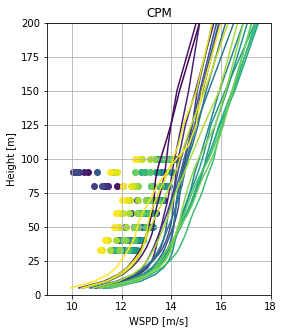

In [34]:
ddarrCPM = ds_10mrs_cpm.sel(station='ARR09').datetime
ddarrOBS = ds_obs.datetime
f, ax = plt.subplots(figsize = (4,5))
NT = len(ddarrCPM)
cmap = plt.cm.viridis( np.linspace( 0, 1, NT ) )

ct = 0
for dd in ds_10mrs_cpm.datetime:
    
    
    indCPM = np.where(ddarrCPM == dd)[0][0]
    indOBS = np.where(ddarrOBS == dd)[0][0]
    
    ax.plot( ds_10mrs_cpm.sel(station='ARR09').isel(datetime=indCPM).wspd, (ds_10mrs_cpm.ph.values[0,:,0]), color = cmap[ct] )
    ax.scatter( ds_obs.isel( datetime = indOBS).wspd, ds_obs.spd_levels, color = cmap[ct] )
    ct+=1
    
ax.grid()
ax.set_xlabel('WSPD [m/s]')    
ax.set_ylabel('Height [m]')
ax.set_title('CPM')

ax.set_xlim([9., 18.])
ax.set_ylim([0., 200.])

(0.0, 200.0)

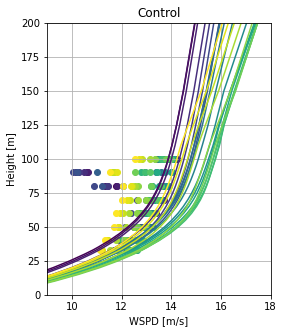

In [35]:
ddarrCONTROL = ds_10mrs_control.sel(station='ARR09').datetime

f, ax = plt.subplots(figsize = (4,5))
NT = len(ddarrCONTROL)
cmap = plt.cm.viridis( np.linspace( 0, 1, NT ) )

ct = 0
for dd in ds_10mrs_control.datetime:
    
    
    indCONTROL = np.where(ddarrCONTROL == dd)[0][0]
    indOBS = np.where(ddarrOBS == dd)[0][0]
    
    ax.plot( ds_10mrs_control.sel(station='ARR09').isel(datetime=indCONTROL).wspd, (ds_10mrs_control.ph.values[0,:,0]), color = cmap[ct] )
    ax.scatter( ds_obs.isel( datetime = indOBS).wspd, ds_obs.spd_levels, color = cmap[ct] )
    ct+=1
    
ax.grid()
ax.set_xlabel('WSPD [m/s]')    
ax.set_ylabel('Height [m]')
ax.set_title('Control')

ax.set_xlim([9., 18.])
ax.set_ylim([0., 200.])

(0.0, 200.0)

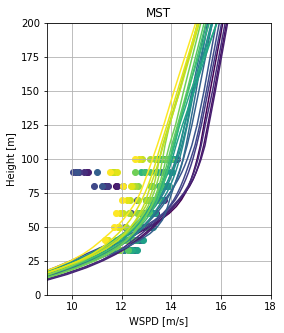

In [40]:
ddarrCONTROL = ds_10mrs_control.sel(station='ARR09').datetime

f, ax = plt.subplots(figsize = (4,5))
NT = len(ddarrCONTROL)
cmap = plt.cm.viridis( np.linspace( 0, 1, NT ) )

ct = 0
for dd in ds_10mrs_control.datetime:
    
    
    indCONTROL = np.where(ddarrCONTROL == dd)[0][0]
    indOBS = np.where(ddarrOBS == dd)[0][0]
    
    ax.plot( ds_mst.isel(minutes=indCONTROL).wspd, (ds_mst.hgt), color = cmap[ct] )
    ax.scatter( ds_obs.isel( datetime = indOBS).wspd, ds_obs.spd_levels, color = cmap[ct] )
    ct+=1
    
ax.grid()
ax.set_xlabel('WSPD [m/s]')    
ax.set_ylabel('Height [m]')
ax.set_title('MST')

ax.set_xlim([9., 18.])
ax.set_ylim([0., 200.])

(0.0, 200.0)

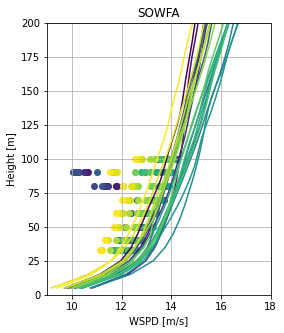

In [36]:
ddarrSOWFA = dssowfa.isel(station=0).datetime

f, ax = plt.subplots(figsize = (4,5))
NT = len(ddarrCONTROL)
cmap = plt.cm.viridis( np.linspace( 0, 1, NT ) )

ct = 0
for dd in ds_10mrs_control.datetime:
    
    
    indCONTROL = np.where(ddarrCONTROL == dd)[0][0]
    indOBS = np.where(ddarrOBS == dd)[0][0]
    
    ax.plot( dssowfa.sel(station=0).isel(datetime=indCONTROL).wspd, (dssowfa.height), color = cmap[ct] )
    ax.scatter( ds_obs.isel( datetime = indOBS).wspd, ds_obs.spd_levels, color = cmap[ct] )
    ct+=1
    
ax.grid()
ax.set_xlabel('WSPD [m/s]')    
ax.set_ylabel('Height [m]')
ax.set_title('SOWFA')

ax.set_xlim([9., 18.])
ax.set_ylim([0., 200.])

#### Interpolate to height of observations

In [44]:
from scipy.interpolate import interp1d

NT = len(ds_10mrs_cpm.datetime.values)
Nspdlevs = len(ds_obs.spd_levels.values)

wspd_cpm_interp = np.empty( [Nspdlevs, NT])
wspd_mst_interp = np.empty( [Nspdlevs, NT] )
wspd_control_interp = np.empty( [Nspdlevs, NT] )
wspd_sowfa_interp = np.empty( [Nspdlevs, NT] )
wspd_obs = np.empty( [Nspdlevs, NT] )

for ti in range(0, NT):
    finterp_CPM = interp1d( ds_10mrs_cpm.ph.values[0,:,0], \
                            ds_10mrs_cpm.sel(station='ARR09').isel(datetime=ti).wspd )
                            
    
    finterp_MST = interp1d( ds_mst.hgt.values, \
                            ds_mst.isel(minutes=ti).wspd )
    
    finterp_CONTROL = interp1d(  ds_10mrs_control.ph.values[0,:,0], \
                            ds_10mrs_control.sel(station='ARR09').isel(datetime=ti).wspd )
    
    finterp_SOWFA = interp1d( dssowfa.height, \
                            dssowfa.sel(station=0).isel(datetime=ti).wspd )
    
    wspd_cpm_interp[:,ti] = finterp_CPM( ds_obs.spd_levels.values )
    wspd_mst_interp[:,ti] = finterp_MST( ds_obs.spd_levels.values )    
    wspd_sowfa_interp[:,ti] = finterp_SOWFA( ds_obs.spd_levels.values )    
    wspd_control_interp[:,ti] = finterp_CONTROL( ds_obs.spd_levels.values )
    wspd_obs[:,ti] = ds_obs.wspd.isel( datetime = ti ).values
    print(f"{ti} of {NT}")

0 of 23
1 of 23
2 of 23
3 of 23
4 of 23
5 of 23
6 of 23
7 of 23
8 of 23
9 of 23
10 of 23
11 of 23
12 of 23
13 of 23
14 of 23
15 of 23
16 of 23
17 of 23
18 of 23
19 of 23
20 of 23
21 of 23
22 of 23


In [46]:
from Vertical_Profile_Functions import bulk_shear, integrated_shear

In [47]:
#Calculate bulk shear

BS_OBS = np.empty(NT)
BS_CPM = np.empty(NT)
BS_SOWFA = np.empty(NT)
BS_CONTROL =  np.empty(NT)
BS_MST = np.empty(NT)

IS_OBS = np.empty(NT)
IS_CPM = np.empty(NT)
IS_SOWFA = np.empty(NT)
IS_CONTROL =  np.empty(NT)
IS_MST = np.empty(NT)

for ti in range(0,NT):
    BS_OBS[ti] = bulk_shear( ds_obs.spd_levels, wspd_obs[:,ti])
    BS_CPM[ti] = bulk_shear( ds_obs.spd_levels, wspd_cpm_interp[:,ti])
    BS_SOWFA[ti] = bulk_shear( ds_obs.spd_levels, wspd_sowfa_interp[:,ti])    
    BS_CONTROL[ti] = bulk_shear( ds_obs.spd_levels, wspd_control_interp[:,ti])
    BS_MST[ti] = bulk_shear( ds_obs.spd_levels, wspd_mst_interp[:,ti])    
    
    IS_OBS[ti] = integrated_shear( ds_obs.spd_levels, wspd_obs[:,ti])
    IS_CPM[ti] = integrated_shear( ds_obs.spd_levels, wspd_cpm_interp[:,ti])
    IS_SOWFA[ti] = integrated_shear( ds_obs.spd_levels, wspd_sowfa_interp[:,ti])    
    IS_CONTROL[ti] = integrated_shear( ds_obs.spd_levels, wspd_control_interp[:,ti])
    IS_MST[ti] = integrated_shear( ds_obs.spd_levels, wspd_mst_interp[:,ti])

In [50]:
import pandas as pd
t_obs = pd.to_datetime( ds_10mrs_cpm.datetime.values )
z_obs = ds_obs.spd_levels

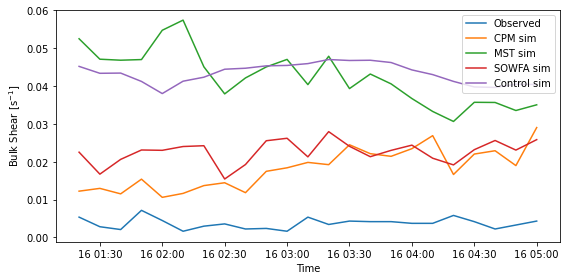

In [56]:
f, ax = plt.subplots(figsize = (8,4) )
ax.plot( t_obs, BS_OBS, label = 'Observed')
ax.plot( t_obs, BS_CPM, label = 'CPM sim')
ax.plot( t_obs, BS_MST, label = 'MST sim')
ax.plot( t_obs, BS_SOWFA, label = 'SOWFA sim')
ax.plot( t_obs, BS_CONTROL, label = 'Control sim')

ax.set_ylabel('Bulk Shear [s$^{-1}$]')
ax.set_xlabel('Time')
ax.legend(loc = 'best')

plt.tight_layout()

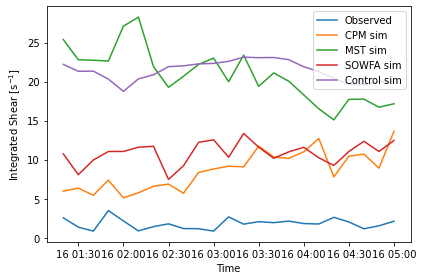

In [53]:
f, ax = plt.subplots()
ax.plot( t_obs, IS_OBS, label = 'Observed')
ax.plot( t_obs, IS_CPM, label = 'CPM sim')
ax.plot( t_obs, IS_MST, label = 'MST sim')
ax.plot( t_obs, IS_SOWFA, label = 'SOWFA sim')
ax.plot( t_obs, IS_CONTROL, label = 'Control sim')

ax.set_ylabel('Integrated Shear [s$^{-1}$]')
ax.set_xlabel('Time')
ax.legend(loc = 'best')

plt.tight_layout()

Text(0.5, 0, 'Time')

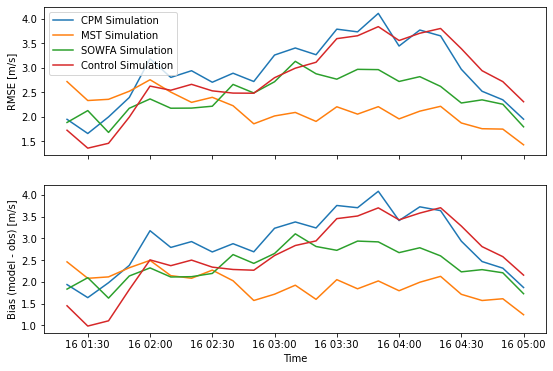

In [58]:
NZobs = len(z_obs)

vRMSE_CPM     = np.sqrt( ( ( wspd_obs - wspd_cpm_interp )**2. ).sum(0) / NZobs )
vRMSE_MST = np.sqrt( ( ( wspd_obs - wspd_mst_interp )**2. ).sum(0) / NZobs )
vRMSE_SOWFA = np.sqrt( ( ( wspd_obs - wspd_sowfa_interp )**2. ).sum(0) / NZobs )
vRMSE_CONTROL = np.sqrt( ( ( wspd_obs - wspd_control_interp )**2. ).sum(0) / NZobs )

vBIAS_CPM     = np.mean( wspd_cpm_interp - wspd_obs, axis = 0 )
vBIAS_MST = np.mean( wspd_mst_interp - wspd_obs, axis = 0 )
vBIAS_SOWFA     = np.mean( wspd_sowfa_interp - wspd_obs, axis = 0 )
vBIAS_CONTROL = np.mean( wspd_control_interp - wspd_obs, axis = 0 )

f, (ax1, ax2) = plt.subplots( nrows = 2, ncols = 1, sharex = True, figsize = (9,6) )
ax1.plot( t_obs, vRMSE_CPM, label = 'CPM Simulation')
ax1.plot( t_obs, vRMSE_MST, label = 'MST Simulation')
ax1.plot( t_obs, vRMSE_SOWFA, label = 'SOWFA Simulation')
ax1.plot( t_obs, vRMSE_CONTROL, label = 'Control Simulation')

ax1.legend(loc = 'best')

ax2.plot( t_obs, vBIAS_CPM, label = 'CPM Simulation')
ax2.plot( t_obs, vBIAS_MST, label = 'MST Simulation')
ax2.plot( t_obs, vBIAS_SOWFA, label = 'SOWFA Simulation')
ax2.plot( t_obs, vBIAS_CONTROL, label = 'Control Simulation')

ax1.set_ylabel('RMSE [m/s]')
ax2.set_ylabel('Bias (model - obs) [m/s]')

ax2.set_xlabel('Time')

(20.0, 105.0)

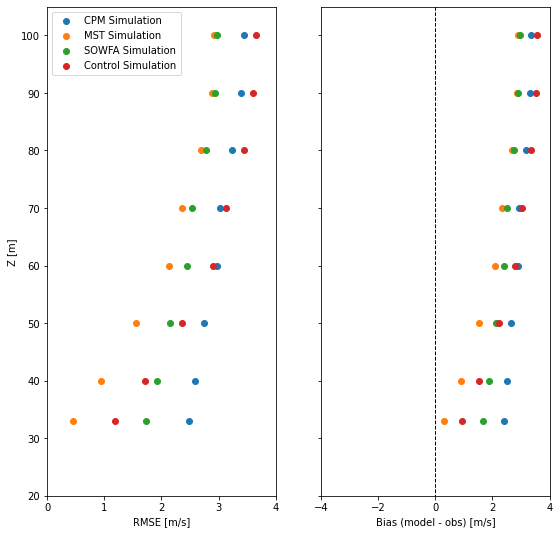

In [64]:
NTobs = len(t_obs)
hRMSE_CPM     = np.sqrt( ( np.nansum(( wspd_obs - wspd_cpm_interp )**2., axis=1 ) / NTobs ) )
hRMSE_CONTROL = np.sqrt( ( np.nansum(( wspd_obs - wspd_control_interp )**2., axis = 1 ) / NTobs ) )
hRMSE_MST = np.sqrt( ( np.nansum(( wspd_obs - wspd_mst_interp )**2., axis = 1 ) / NTobs ) )
hRMSE_SOWFA = np.sqrt( ( np.nansum(( wspd_obs - wspd_sowfa_interp )**2., axis = 1 ) / NTobs ) )

hBIAS_CPM     = np.nanmean( wspd_cpm_interp - wspd_obs, axis = 1 )
hBIAS_CONTROL = np.nanmean( wspd_control_interp - wspd_obs, axis = 1 )
hBIAS_MST = np.nanmean( wspd_mst_interp - wspd_obs, axis = 1 )
hBIAS_SOWFA = np.nanmean( wspd_sowfa_interp - wspd_obs, axis = 1 )

#print(hBIAS_CPM, hRMSE_CPM)

f, (ax1, ax2) = plt.subplots( nrows = 1, ncols = 2, sharey = True, figsize = (9,9) )
ax1.scatter( hRMSE_CPM, z_obs, label = 'CPM Simulation')
ax1.scatter( hRMSE_MST, z_obs, label = 'MST Simulation')
ax1.scatter( hRMSE_SOWFA, z_obs, label = 'SOWFA Simulation')
ax1.scatter( hRMSE_CONTROL, z_obs, label = 'Control Simulation')

ax1.legend(loc = 'best')

ax2.scatter( hBIAS_CPM, z_obs, label = 'CPM Simulation')
ax2.scatter( hBIAS_MST, z_obs, label = 'MST Simulation')
ax2.scatter( hBIAS_SOWFA, z_obs, label = 'SOWFA Simulation')
ax2.scatter( hBIAS_CONTROL, z_obs, label = 'Control Simulation')

ax1.set_xlabel('RMSE [m/s]')
ax2.set_xlabel('Bias (model - obs) [m/s]')

ax1.set_xlim([0., 4.])
ax2.set_xlim([-4., 4.])
ax1.set_ylim([0., 101.])

zero_line_x = np.zeros( [101] )
zero_line_y = np.linspace(0, 120, 101)
ax2.plot( zero_line_x, zero_line_y, 'k--', linewidth = 1.0 )

ax1.set_ylabel('Z [m]')
ax1.set_ylim([20., 105])

## Spectra

### Read and postprocess turbulent data<br>
From Regis's notebook

In [16]:
LESfrom = ds_cpm.isel(datetime=0).datetime
LESto = ds_cpm.isel(datetime=-1).datetime

In [17]:
obspath = '/g/g12/lassman1/mmc/Data/FINO'
obsrajfull = xr.open_dataset(os.path.join(obspath, 'FINO1_obs_10hz.nc'))

In [18]:
# Get only the period of interest
obs = obsrajfull.sel(datetime=slice(LESfrom,LESto))

In [19]:
print(obs.wspd)
print(obs.dims)

<xarray.DataArray 'wspd' (datetime: 132749, height: 3)>
[398247 values with dtype=float64]
Coordinates:
  * height    (height) float64 40.0 60.0 80.0
  * datetime  (datetime) datetime64[ns] 2010-05-16T01:20:00.100000 ... 2010-0...
Frozen(SortedKeysDict({'height': 3, 'datetime': 132749}))


## Import and use calc_spectra

In [20]:
if not do_spectra:
    sys.exit()

SystemExit: 

/g/g12/lassman1/anaconda3/envs/mmc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
from mmctools.helper_functions import calc_spectra

In [ ]:
psdobs = calc_spectra(obs,
                      var_oi=['u','v','w','wspd'],
                      spectra_dim='datetime',
                      level_dim='height',
                      window='hamming',
                      window_length='30min',
                     )

In [ ]:
#ds_cpm = ds_cpm.datetime.round('1M')
ds_cpm_10Hz = ds_cpm.resample({'datetime' : '0.2S'}).nearest()

In [ ]:
psd_wrfcpm = calc_spectra(ds_cpm_10Hz.sel(station='ARR09'),
                        var_oi=['u','v','w','wspd'],
                        spectra_dim='datetime',
                        average_dim='i',
                        level_dim='nz',
                        window='hamming',
                        window_length='30min',
                        #level=[0,1]
                       )

In [ ]:
#ds_cpm = ds_cpm.datetime.round('1M')
ds_control_10Hz = ds_control.resample({'datetime' : '0.2S'}).nearest()

In [ ]:
psd_wrfcontrol = calc_spectra(ds_control_10Hz.sel(station='ARR09'),
                        var_oi=['u','v','w','wspd'],
                        spectra_dim='datetime',
                        average_dim='i',
                        level_dim='nz',
                        window='hamming',
                        window_length='30min',
                        #level=[0,1]
                       )

In [ ]:
#do all of the vertical masts now
psd_wrfcpm_ARR06 = calc_spectra(ds_cpm_10Hz.sel(station='ARR06'),
                        var_oi=['u','v','w','wspd'],
                        spectra_dim='datetime',
                        average_dim='i',
                        level_dim='nz',
                        window='hamming',
                        window_length='30min',
                        #level=[0,1]
                       )
psd_wrfcpm_ARR07 = calc_spectra(ds_cpm_10Hz.sel(station='ARR07'),
                        var_oi=['u','v','w','wspd'],
                        spectra_dim='datetime',
                        average_dim='i',
                        level_dim='nz',
                        window='hamming',
                        window_length='30min',
                        #level=[0,1]
                       )
psd_wrfcpm_ARR08 = calc_spectra(ds_cpm_10Hz.sel(station='ARR08'),
                        var_oi=['u','v','w','wspd'],
                        spectra_dim='datetime',
                        average_dim='i',
                        level_dim='nz',
                        window='hamming',
                        window_length='30min',
                        #level=[0,1]
                       )

In [ ]:
#do all of the vertical masts now
psd_wrfcontrol_ARR06 = calc_spectra(ds_control_10Hz.sel(station='ARR06'),
                        var_oi=['u','v','w','wspd'],
                        spectra_dim='datetime',
                        average_dim='i',
                        level_dim='nz',
                        window='hamming',
                        window_length='30min',
                        #level=[0,1]
                       )
psd_wrfcontrol_ARR07 = calc_spectra(ds_control_10Hz.sel(station='ARR07'),
                        var_oi=['u','v','w','wspd'],
                        spectra_dim='datetime',
                        average_dim='i',
                        level_dim='nz',
                        window='hamming',
                        window_length='30min',
                        #level=[0,1]
                       )
psd_wrfcontrol_ARR08 = calc_spectra(ds_control_10Hz.sel(station='ARR08'),
                        var_oi=['u','v','w','wspd'],
                        spectra_dim='datetime',
                        average_dim='i',
                       level_dim='nz',
                        window='hamming',
                        window_length='30min',
                        #level=[0,1]
                       )

In [ ]:
print(psd_wrfcpm.coords)
print(psd_wrfcpm.dims)
print(len(psd_wrfcpm.frequency))
print(psd_wrfcpm.variables)
print(ds_cpm.nz)
print(ds_cpm.ph.sel(station = 'ARR09').isel(datetime = 0).values)

nz_80 = np.where(ds_cpm.ph.sel(station = 'ARR09').isel(datetime = 0).values == 80)[0][0]
nz_60 = np.where(ds_cpm.ph.sel(station = 'ARR09').isel(datetime = 0).values == 60)[0][0]
nz_40 = np.where(ds_cpm.ph.sel(station = 'ARR09').isel(datetime = 0).values == 40)[0][0]

## Plot spectra

In [ ]:
from mmctools.windtools.windtools.plotting import plot_spectrum

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

_,ax = plot_spectrum(
    datasets={'Obs':psdobs.sel(height=80).to_dataframe(), \
              'WRF-CPM':psd_wrfcpm.sel(nz=nz_80).mean(dim='i').to_dataframe(), \
              'WRF-CONTROL':psd_wrfcontrol.sel(nz=nz_80).mean(dim='i').to_dataframe(),},
    #height=80,
    #times=spectraTimes,
    fields='wspd',
    freqlimits=(1e-3,1),
    fieldlimits={'wspd':(1e-3,1e2)},
    showlegend=False,
    fig=fig, ax=axs[0]
)
ax.set_title('80m WRF-CPM / WRF-Control / 80m obs')



_,ax = plot_spectrum(
    datasets={'Obs':psdobs.sel(height=60).to_dataframe(), \
              'WRF-CPM':psd_wrfcpm.sel(nz=nz_60,method='nearest').mean(dim='i').to_dataframe(), \
              'WRF-CONTROL':psd_wrfcontrol.sel(nz=nz_60,method='nearest').mean(dim='i').to_dataframe(), },
    #height=80,
    #times=spectraTimes,
    fields='wspd',
    freqlimits=(1e-3,1),
    fieldlimits={'wspd':(1e-3,1e2)},
    showlegend=False,
    fig=fig, ax=axs[1]
)
ax.set_title('60m WRF-CPM / WRF-Control / 60m obs')


_,ax = plot_spectrum(
    datasets={'Obs':psdobs.sel(height=40).to_dataframe(), \
              'WRF-CPM':psd_wrfcpm.sel(nz=nz_40,method='nearest').mean(dim='i').to_dataframe(), \
              'WRF-CONTROL':psd_wrfcontrol.sel(nz=nz_40,method='nearest').mean(dim='i').to_dataframe(),},
    #height=80,
    #times=spectraTimes,
    fields='wspd',
    freqlimits=(1e-3,1),
    fieldlimits={'wspd':(1e-3,1e2)},
    fig=fig, ax=axs[2]
)
ax.set_title('45m WRF-CPM / WRF-Control / 40m obs')

plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13,4))

_,ax = plot_spectrum(
    datasets={#'Obs':psdobs.sel(height=80).to_dataframe(), \
              'ARR06':psd_wrfcpm_ARR06.sel(nz=nz_80).mean(dim='i').to_dataframe(), \
              'ARR07':psd_wrfcpm_ARR07.sel(nz=nz_80).mean(dim='i').to_dataframe(), \
              'ARR08':psd_wrfcpm_ARR08.sel(nz=nz_80).mean(dim='i').to_dataframe(), \
              'ARR09':psd_wrfcpm.sel(nz=nz_80).mean(dim='i').to_dataframe(),},
    #height=80,
    #times=spectraTimes,
    fields='wspd',
    freqlimits=(1e-3,1),
    fieldlimits={'wspd':(1e-3,1e2)},
    showlegend=False,
    fig=fig, ax=axs[0]
)
ax.set_title('80m WRF-CPM')



_,ax = plot_spectrum(
    datasets={#'Obs':psdobs.sel(height=60).to_dataframe(), \
              'ARR06':psd_wrfcontrol_ARR06.sel(nz=nz_80,method='nearest').mean(dim='i').to_dataframe(), \
              'ARR07':psd_wrfcontrol_ARR07.sel(nz=nz_80,method='nearest').mean(dim='i').to_dataframe(), \
              'ARR08':psd_wrfcontrol_ARR08.sel(nz=nz_80,method='nearest').mean(dim='i').to_dataframe(), \
              'ARR09':psd_wrfcontrol.sel(nz=nz_80,method='nearest').mean(dim='i').to_dataframe(), },
    #height=80,
    #times=spectraTimes,
    fields='wspd',
    freqlimits=(1e-3,1),
    fieldlimits={'wspd':(1e-3,1e2)},
    showlegend=False,
    fig=fig, ax=axs[1]
)
ax.set_title('80m WRF CONTROL')


plt.show()